In [1]:
import numpy as np
import pandas as pd
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from numpy.random import randn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
R = 4.125    # Radius of the spiral (8.25 meter diameter, so radius = 4.125 meters)
N = 3.30     # Number of turns
H = 13       # Total height (13 meters)
T = 1300     # Number of steps (adjustable)

# Calculate the spiral points
true_position = np.array([[-R * np.cos(i * (2 * np.pi * N) / T),  R * np.sin(i * (2 * np.pi * N) / T), 
                    (i / T) * H] for i in range(T)])

In [10]:
df = pd.read_csv("sensor_data.csv")
df["v_x"] = df["omega_x"]*R
df["v_y"] = df["omega_y"]*R
df["v_z"] = df["omega_z"]*R
df["a_x"] -= df["g_x"]
df["a_y"] -= df["g_y"]
df["a_z"] -= df["g_z"]
df.head()

,a_x,a_y,a_z,m_x,m_y,m_z,omega_x,omega_y,omega_z,g_x,g_y,g_z,Pressure,Temperature,Timestamp,v_x,v_y,v_z
0,-1.71,-0.43,0.55,21.25,-9.19,-38.38,25.06,15.50,-55.13,-3.49,-2.88,8.69,102804.18,23.27,2024-11-12 16:34:33,103.37250,63.93750,-227.41125
1,-1.82,0.25,-0.45,22.19,-8.88,-38.69,38.06,25.69,-31.62,-3.59,-2.74,8.69,102804.01,23.27,2024-11-12 16:34:33,156.99750,105.97125,-130.43250
2,-1.42,0.06,-1.45,23.69,-9.69,-37.88,9.38,-9.00,0.06,-3.65,-2.42,8.76,102804.00,23.27,2024-11-12 16:34:33,38.69250,-37.12500,0.24750
3,-2.69,1.67,0.16,24.06,-10.88,-35.88,43.25,15.56,-2.75,-3.66,-2.15,8.83,102804.19,23.27,2024-11-12 16:34:33,178.40625,64.18500,-11.34375
4,-1.93,0.73,1.19,25.25,-11.56,-35.88,33.44,1.37,-4.00,-3.61,-2.57,8.74,102804.32,23.26,2024-11-12 16:34:33,137.94000,5.65125,-16.50000


In the very simple terms, Kalman filter is an optimal estimation algorithm. It is used when we cannot really see or measure something directly. In this very case, we are predicting the somebody's position based on the information on their initial position $(x,y,z)^T$. Based on those we are also measuring $(v_x,v_y,v_z)$.

The Kalman filter works in two steps:

1. **predict**: during this step we are predicting what is going to be the position at the next sample point
2. **update**: compares the estimate from **predict** with the measurement and updates it based on that, also the filter keeps the information on the estimate uncertainty

And we basically have a while loop with those.

    while(walking):
        extimate = predict(next position)
        update(estimate)

# define parameters
- $\bf{F}$: state transition matrix ($n\times n$)
- $\vec{x}$: state vector ($n\times 1$)
- $\bf{P}$: state covariance matrix ($n\times n$)
- $\bf{Q}$: process noise covariance matrix ($n\times n$)
- $\bf{H}$: measurement covariance matrix ($m\times n$)
- $\vec{z}$: measurement vector ($m\times 1$)
- $\bf{K}$: Kalman Gain Matrix ($n\times m$)

The state vector is vector of positions and measurements. $$\vec{x}=\begin{pmatrix} x&y&z&v_z&v_y&v_z&a_x&a_y&a_z&p \end{pmatrix}^T$$

The state transition matrix is a description of how our position changes at each sampling instant. This we take from physics, the classic $x(t)=x_0+v(t)\cdot t$ and $a(t)=x_0+v(t)\cdot t + \frac{1}{2}a(t)\cdot t^2$.

The rest is basically covariance matrices that help us use the information about the noise and environment to optimise the filter. They also change in each iteration.

In [31]:
measurements = np.array([ df["v_x"], df["v_y"], df["v_z"], df["a_x"], df["a_y"], df["a_z"] ])

R = np.cov(measurements.T)
diff = np.diff(measurements, axis=0)
Q = np.cov(diff.T)

In [57]:
kf = KalmanFilter(dim_x=9, dim_z=6)
kf.x = np.zeros((9,1))
dt = 0.4  # Time step
F = np.array([
    [1, 0, 0, dt, 0, 0, 0.5*dt**2, 0, 0],
    [0, 1, 0, 0, dt, 0, 0, 0.5*dt**2, 0],
    [0, 0, 1, 0, 0, dt, 0, 0, 0.5*dt**2],
    [0, 0, 0, 1, 0, 0, dt, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, dt, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, dt],
    [0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1]
])
kf.H = np.array([
    [0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1]
])
q = 0.001
kf.Q = q**2 * np.array([
    [dt**3/3, 0, 0, dt**2/2, 0, 0, dt**3/6, 0, 0],
    [0, dt**3/3, 0, 0, dt**2/2, 0, 0, dt**3/6, 0],
    [0, 0, dt**3/3, 0, 0, dt**2/2, 0, dt**3/6, 0],
    [dt**2/2, 0, 0, dt, 0, 0, dt**2/2, 0, 0],
    [0, dt**2/2, 0, 0, dt, 0, 0, dt**2/2, 0],
    [0, 0, dt**2/2, 0, 0, dt, 0, 0, dt**2/2],
    [dt**3/6, 0, 0, dt**2/2, 0, 0, dt**2/2, 0, 0],
    [0, dt**3/6, 0, 0, dt**2/2, 0, 0, dt**2/2, 0],
    [0, 0, dt**3/6, 0, 0, dt**2/2, 0, dt**2/2, 0]
])

kf.R = np.eye(6) * 0.01
kf.P *= 100

In [58]:
measurements = np.array([ df["v_x"], df["v_y"], df["v_z"], df["a_x"], df["a_y"], df["a_z"] ])
predicted_x, predicted_y, predicted_z = [], [], []

for z in measurements.T:
    z = z.reshape(6,1)
    kf.predict()
    kf.update(z)

    predicted_x.append(kf.x[0])
    predicted_y.append(kf.x[1])
    predicted_z.append(kf.x[2])

    # kf.x[0] = integrated_vx*dt
    # kf.x[1] = integrated_vy*dt
    # kf.x[2] = integrated_vz*dt
    

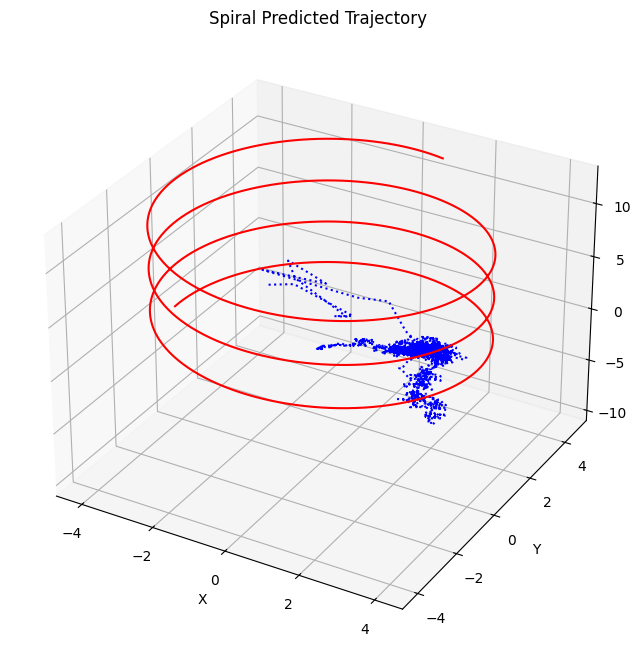

In [59]:
#t = np.arange(0,len(predicted_x)*dt, dt)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(predicted_x, predicted_y, predicted_z, 'b:', label='Predicted')
ax.plot(true_position[:,0], true_position[:,1], true_position[:,2], 'r-', label="True")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Spiral Predicted Trajectory')
plt.show()